# CNN trainiert mit den erweiternten Daten

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.0')

Using TensorFlow backend.


2.0.6


In [8]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.19.0')

0.20.1


## Laden und und Mischen der Bild-Daten
### wir nehmen eine Mischung aus den originalen und den transformieren Bilddaten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/augmented-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  5267k      0 --:--:-- --:--:-- --:--:-- 6033k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.7M  100 16.7M    0     0  21.6M      0 --:--:-- --:--:-- --:--:-- 21.8M


In [10]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile('speed-limit-signs.zip')
zip.extractall('.')
zip = ZipFile('augmented-signs.zip')
zip.extractall('.')

In [12]:
!ls -lh

total 20M
drwxrwxr-x 8 ubuntu ubuntu 4.0K Jul 21 16:58 augmented-signs
-rw-rw-r-- 1 ubuntu ubuntu  17M Aug 30 11:48 augmented-signs.zip
-rw-rw-r-- 1 ubuntu ubuntu  32K Aug 30 11:46 CNN-Full.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 121K Aug 30 11:46 CNN.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 110K Aug 30 11:46 CNN-Mixed.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  98K Aug 30 11:46 CNN-Original.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  22K Aug 30 11:46 cnn-train-augmented.ipynb
drwxrwxr-x 3 ubuntu ubuntu 4.0K Jul 21 16:50 __MACOSX
drwxrwxr-x 2 ubuntu ubuntu 4.0K Aug  9 07:12 models
-rw------- 1 ubuntu ubuntu 109K Aug 30 11:48 nohup.out
-rw-rw-r-- 1 ubuntu ubuntu   36 Aug  8 09:49 sample_iris.json
drwxrwxr-x 8 ubuntu ubuntu 4.0K Jul 21 16:58 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 30 11:48 speed-limit-signs.zip


In [13]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    y = np.array(labels)
    y = to_categorical(y, num_categories)
    X = np.array(images64)
    return X, y

In [14]:
# Load datasets.
ROOT_PATH = "./"

In [15]:
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
original_images, original_labels = load_data(original_dir, type=".ppm")

In [16]:
data_dir = os.path.join(ROOT_PATH, "augmented-signs")
augmented_images, augmented_labels = load_data(data_dir, type=".png")

In [17]:
all_images = np.vstack((original_images, augmented_images))

In [18]:
all_labels = np.vstack((original_labels, augmented_labels))

In [19]:
# https://stackoverflow.com/a/4602224
p = numpy.random.permutation(len(all_labels))

In [20]:
shuffled_images = all_images[p]

In [21]:
shuffled_labels = all_labels[p]

In [22]:
# Turn this around if you want the large training set using augmented data or the original one

# X, y = original_images, original_labels
# X, y = augmented_images, augmented_labels
X, y = shuffled_images, shuffled_labels

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
X_train.shape, y_train.shape

((3335, 64, 64, 3), (3335, 6))

In [26]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this is important, try and vary between .4 and .75
drop_out = 0.7

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [27]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [30]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [31]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [32]:
!rm -r tf_log
!rm -r model-checkpoints
!mkdir model-checkpoints

rm: cannot remove 'tf_log': No such file or directory
rm: cannot remove 'model-checkpoints': No such file or directory


In [ ]:
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 1000
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
%time model.fit(X_train, y_train, epochs=1500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 2668 samples, validate on 667 samples
Epoch 1/1500
2668/2668 [==============================] - 31s - loss: 1.8513 - acc: 0.1960 - val_loss: 1.7897 - val_acc: 0.2474
Epoch 2/1500
2668/2668 [==============================] - 10s - loss: 1.7620 - acc: 0.2103 - val_loss: 1.7868 - val_acc: 0.2459
Epoch 3/1500
2668/2668 [==============================] - 10s - loss: 1.7510 - acc: 0.2208 - val_loss: 1.7893 - val_acc: 0.2624
Epoch 4/1500
2668/2668 [==============================] - 11s - loss: 1.7332 - acc: 0.2339 - val_loss: 1.7903 - val_acc: 0.2144
Epoch 5/1500
2668/2668 [==============================] - 11s - loss: 1.7259 - acc: 0.2339 - val_loss: 1.7854 - val_acc: 0.2654
Epoch 6/1500
2668/2668 [==============================] - 11s - loss: 1.7198 - acc: 0.2429 - val_loss: 1.7912 - val_acc: 0.1634
Epoch 7/1500
2668/2668 [==============================] - 11s - loss: 1.7148 - acc: 0.2350 - val_loss: 1.7906 - val_acc: 0.1769
Epoch 8/1500
2668/2668 [==============================] -

2668/2668 [==============================] - 11s - loss: 0.7205 - acc: 0.7178 - val_loss: 1.0197 - val_acc: 0.6072
Epoch 128/1500
2668/2668 [==============================] - 11s - loss: 0.7631 - acc: 0.6990 - val_loss: 0.9675 - val_acc: 0.6267
Epoch 129/1500
2668/2668 [==============================] - 11s - loss: 0.7543 - acc: 0.7166 - val_loss: 1.1539 - val_acc: 0.5367
Epoch 130/1500
2668/2668 [==============================] - 11s - loss: 0.7788 - acc: 0.7080 - val_loss: 1.0937 - val_acc: 0.5472
Epoch 131/1500
2668/2668 [==============================] - 11s - loss: 0.7451 - acc: 0.7106 - val_loss: 1.0231 - val_acc: 0.6117
Epoch 132/1500
2668/2668 [==============================] - 11s - loss: 0.7310 - acc: 0.7148 - val_loss: 1.0283 - val_acc: 0.5982
Epoch 133/1500
2668/2668 [==============================] - 11s - loss: 0.7189 - acc: 0.7283 - val_loss: 0.9538 - val_acc: 0.6357
Epoch 134/1500
2668/2668 [==============================] - 11s - loss: 0.7196 - acc: 0.7234 - val_loss: 

2668/2668 [==============================] - 11s - loss: 0.2938 - acc: 0.8831 - val_loss: 0.7582 - val_acc: 0.7421
Epoch 254/1500
2668/2668 [==============================] - 11s - loss: 0.2831 - acc: 0.8917 - val_loss: 0.6676 - val_acc: 0.7646
Epoch 255/1500
2668/2668 [==============================] - 11s - loss: 0.2731 - acc: 0.8936 - val_loss: 0.8485 - val_acc: 0.7166
Epoch 256/1500
2668/2668 [==============================] - 11s - loss: 0.2714 - acc: 0.9029 - val_loss: 0.7182 - val_acc: 0.7571
Epoch 257/1500
2668/2668 [==============================] - 11s - loss: 0.2756 - acc: 0.8977 - val_loss: 0.7188 - val_acc: 0.7511
Epoch 258/1500
2668/2668 [==============================] - 11s - loss: 0.2688 - acc: 0.9048 - val_loss: 0.7098 - val_acc: 0.7511
Epoch 259/1500
2668/2668 [==============================] - 11s - loss: 0.2656 - acc: 0.9033 - val_loss: 0.8005 - val_acc: 0.7211
Epoch 260/1500
2668/2668 [==============================] - 11s - loss: 0.3028 - acc: 0.8879 - val_loss: 

2668/2668 [==============================] - 11s - loss: 0.1359 - acc: 0.9483 - val_loss: 0.5198 - val_acc: 0.8246
Epoch 380/1500
2668/2668 [==============================] - 11s - loss: 0.1370 - acc: 0.9475 - val_loss: 0.6502 - val_acc: 0.7991
Epoch 381/1500
2668/2668 [==============================] - 11s - loss: 0.1457 - acc: 0.9528 - val_loss: 0.4266 - val_acc: 0.8531
Epoch 382/1500
2668/2668 [==============================] - 11s - loss: 0.1456 - acc: 0.9468 - val_loss: 0.7333 - val_acc: 0.7616
Epoch 383/1500
2668/2668 [==============================] - 11s - loss: 0.1516 - acc: 0.9464 - val_loss: 0.4511 - val_acc: 0.8636
Epoch 384/1500
2668/2668 [==============================] - 11s - loss: 0.1528 - acc: 0.9490 - val_loss: 0.6997 - val_acc: 0.7901
Epoch 385/1500
2668/2668 [==============================] - 11s - loss: 0.1461 - acc: 0.9442 - val_loss: 0.5259 - val_acc: 0.8126
Epoch 386/1500
2668/2668 [==============================] - 11s - loss: 0.1410 - acc: 0.9501 - val_loss: 

# Sichern des Modells
* unser Modell ist 55 MB groß, das ist ein wirklich großes Modell

In [34]:
model.save('conv-vgg-augmented.hdf5')

In [35]:
!ls -lh

total 75M
drwxrwxr-x 8 ubuntu ubuntu 4.0K Jul 21 16:58 augmented-signs
-rw-rw-r-- 1 ubuntu ubuntu  17M Aug 30 11:48 augmented-signs.zip
-rw-rw-r-- 1 ubuntu ubuntu  32K Aug 30 11:46 CNN-Full.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 121K Aug 30 11:46 CNN.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 110K Aug 30 11:46 CNN-Mixed.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  98K Aug 30 11:46 CNN-Original.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  89K Aug 30 16:32 cnn-train-augmented.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  55M Aug 30 16:34 conv-vgg-augmented.hdf5
drwxrwxr-x 3 ubuntu ubuntu 4.0K Jul 21 16:50 __MACOSX
drwxrwxr-x 2 ubuntu ubuntu 4.0K Aug 30 11:49 model-checkpoints
drwxrwxr-x 2 ubuntu ubuntu 4.0K Aug  9 07:12 models
-rw------- 1 ubuntu ubuntu 132K Aug 30 16:32 nohup.out
-rw-rw-r-- 1 ubuntu ubuntu   36 Aug  8 09:49 sample_iris.json
drwxrwxr-x 8 ubuntu ubuntu 4.0K Jul 21 16:58 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 30 11:48 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 30 11:50 tf_log


In [38]:
# https://transfer.sh/
# Speichert eure Daten für 14 Tage
!curl --upload-file conv-vgg-augmented.hdf5 https://transfer.sh/conv-vgg-augmented.hdf5

# Vortrainiertes Modell
# https://transfer.sh/Cvcar/conv-vgg-augmented.hdf5

https://transfer.sh/Cvcar/conv-vgg-augmented.hdf5

# Bewertung

In [37]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

3335/3335 [==============================] - 5s     


(0.13158953055806424, 0.96131937605687701)

In [39]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

834/834 [==============================] - 4s


(0.46287021040916443, 0.8956834077835083)

# Ausprobieren auf ein paar Test-Daten

In [46]:
import random

# Pick 10 random images for test data set
random.seed(4) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([3, 1, 1, 2, 2, 2, 0, 3, 5, 4])

In [47]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

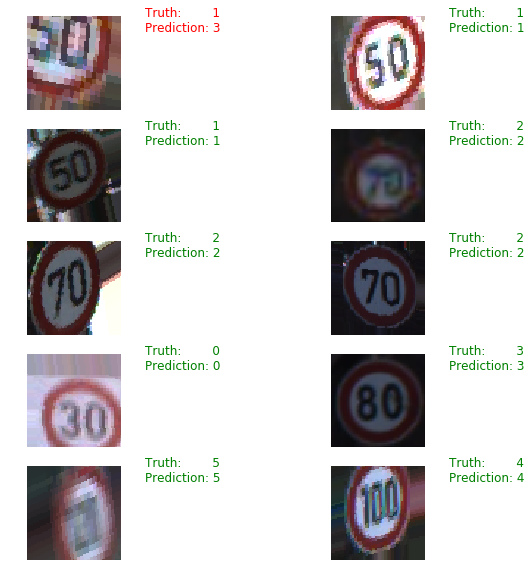

In [48]:
display_prediction(sample_images, ground_truth, predicted_categories)